<a href="https://colab.research.google.com/github/Byeon-MJ/DL_Computer_Vision/blob/main/Face_Alignment_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import dlib
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
RIGHT_EYE = list(range(36,42))
LEFT_EYE = list(range(42, 48))
EYES = list(range(36, 48))

In [ ]:
# 원본 이미지 경로
dataset_paths = ['/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-front/',
                 '/content/gdrive/MyDrive/CV/Face Landmark/image/Gosling-front/',
                 '/content/gdrive/MyDrive/CV/Face Landmark/image/unknown-front/']

# output 이미지 경로
output_paths = ['/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/',
                '/content/gdrive/MyDrive/CV/Face Landmark/image/Gosling-align/',
                '/content/gdrive/MyDrive/CV/Face Landmark/image/unknown-align/']

# 이미지 타입
image_type = '.jpg'

# 학습된 dlib 모델 불러옴
predictor_file = '/content/gdrive/MyDrive/CV/Face Landmark/shape_predictor_68_face_landmarks.dat'

# output 이미지 해상도
OUTPUT_SIZE = (300, 300)

# detector & predictor 정의
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_file)

# rect의 x, y, w, h를 구하는 함수 정의
def getFaceDimension(rect):
    return (rect.left(), rect.top(), rect.right() - rect.left(), rect.bottom() - rect.top())

# Crop 할 좌표를 구하는 함수 정의
def getCropDimension(rect, center):
    width = (rect.right() - rect.left())
    half_width = width // 2
    (centerX, centerY) = center
    startX = centerX - half_width
    endX = centerX + half_width
    startY = rect.top()
    endY = rect.bottom()
    return (startX, endX, startY, endY)

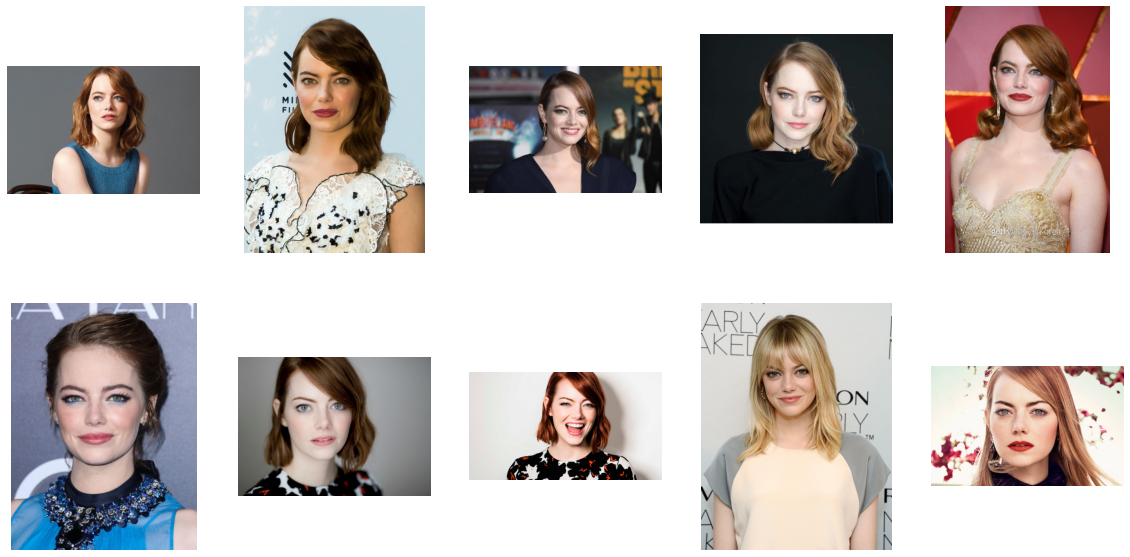

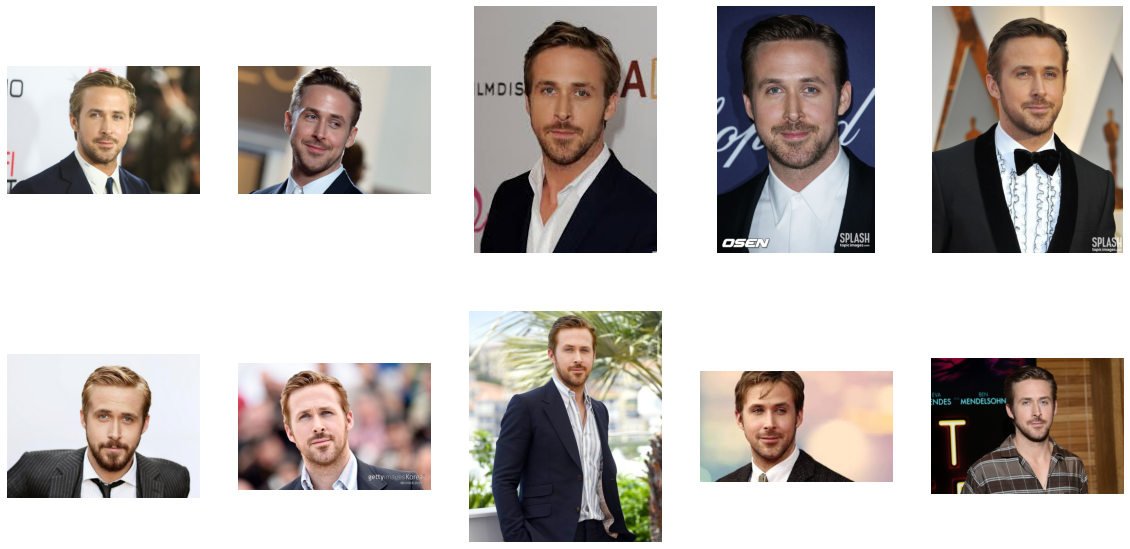

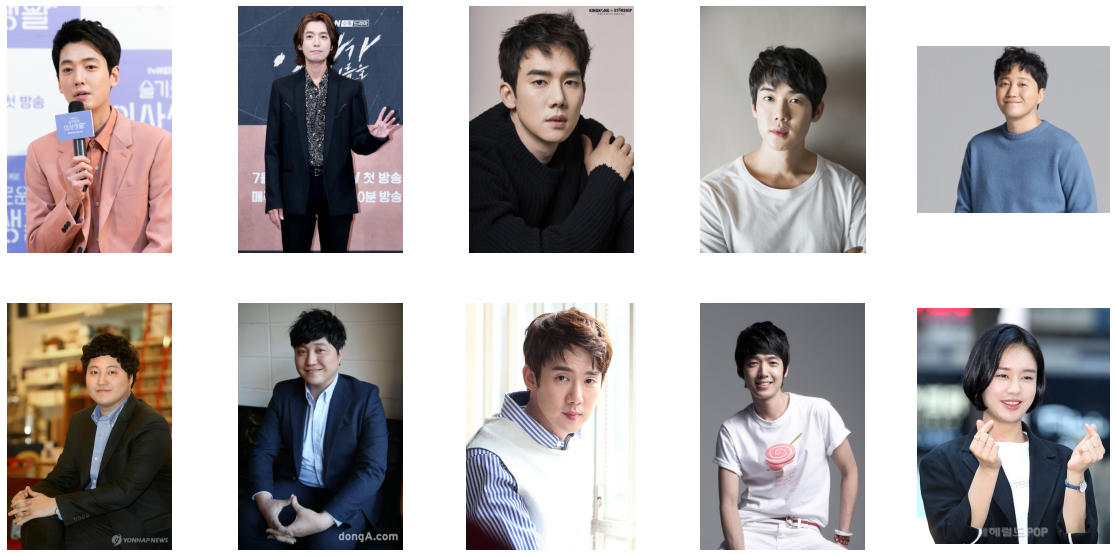

In [ ]:
# 원본 이미지 display
for idx in range(0,3):
    plt.figure(figsize=(20, 10))
    for i in range(1, 11):
        plt.subplot(2, 5, i)
        image_file = dataset_paths[idx] + str(i) +'.jpg'
        image = cv2.imread(image_file)
        plt.imshow(image)
        cvt_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(cvt_img)
        plt.axis('off')
    plt.show()

In [ ]:
for (i, dataset_path) in enumerate(dataset_paths):
    output_path = output_paths[i]
    total_images = os.listdir(dataset_path)

    for idx in range(len(total_images)):
        input_file = dataset_path + str(idx+1) + image_type

        # 원본 이미지를 읽어옴
        image = cv2.imread(input_file)
        # 원본 이미지 copy
        image_origin = image.copy()

        (image_height, image_width) = image.shape[:2]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detector에 의해 얼굴 감지
        rects = detector(gray, 1)

        for (i, rect) in enumerate(rects):
            (x, y, w, h) = getFaceDimension(rect)
            
            # 이미지에 boxing
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # predictor에 의해 감지된 landmark point를 x, y 좌표로 계산
            points = np.matrix([[p.x, p.y] for p in predictor(gray, rect).parts()])
            show_parts = points[EYES]

            # 오른쪽 눈 중앙값 계산
            right_eye_center = np.mean(points[RIGHT_EYE], axis = 0).astype('int')
            # 왼쪽쪽 눈 중앙값 계산
            left_eye_center = np.mean(points[LEFT_EYE], axis = 0).astype('int')

            eye_delta_x = right_eye_center[0, 0] - left_eye_center[0, 0]
            eye_delta_y = right_eye_center[0, 1] - left_eye_center[0, 1]
            # arctan2로 조정각도 계산
            degree = np.degrees(np.arctan2(eye_delta_y, eye_delta_x)) - 180

            # 눈 사이 간격을 Euclidean Distance로 계산(실제 간격)
            eye_distance = np.sqrt((eye_delta_x ** 2) + (eye_delta_y ** 2))

            # alignment 된 눈 사이 간격(조정 거리)
            aligned_eye_distance = left_eye_center[0, 0] - right_eye_center[0, 0]
            
            # 조정된 거리의 스케일
            scale = aligned_eye_distance / eye_distance

            # 두 눈의 중앙점 간의 중앙점을 다시 계산
            eyes_center = (int((left_eye_center[0, 0] + right_eye_center[0, 0]) // 2),
                            int((left_eye_center[0, 1] + right_eye_center[0, 1]) // 2))
            
            rotate = cv2.getRotationMatrix2D(eyes_center, degree, scale)
            rotated = cv2.warpAffine(image_origin, rotate, (image_width, image_height), flags = cv2.INTER_CUBIC)

            # rect에서 Crop 할 이미지의 좌표값을 구해온다.
            (startX, endX, startY, endY) = getCropDimension(rect, eyes_center)

            # 회전된 이미지에서 Crop 될 이미지를 구함
            croped = rotated[startY:endY, startX:endX]

            # Crop 된 이미지를 Output 해상도에 맞게 resizing
            output = cv2.resize(croped, OUTPUT_SIZE)

            # output 파일명, 이미지 저장
            output_file = output_path + str(idx + 1) + image_type
            cv2.imwrite(output_file, output)
            print(output_file + 'is saved')

/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/1.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/2.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/3.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/4.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/5.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/6.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/7.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/8.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/9.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Emma-align/10.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Gosling-align/1.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Gosling-align/2.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Gosling-align/3.jpgis saved
/content/gdrive/MyDrive/CV/Face Landmark/image/Gosling

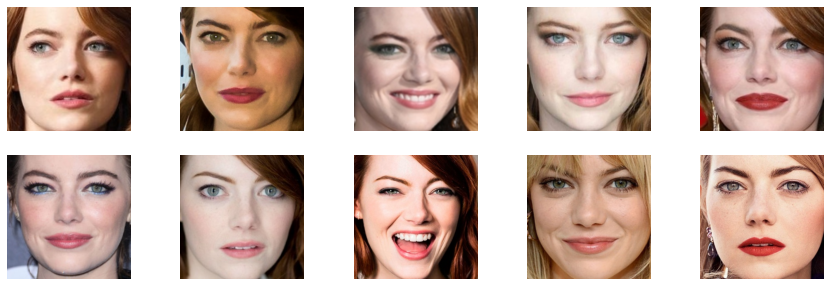

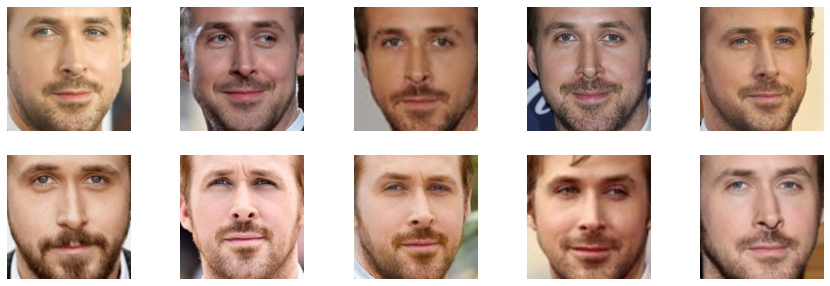

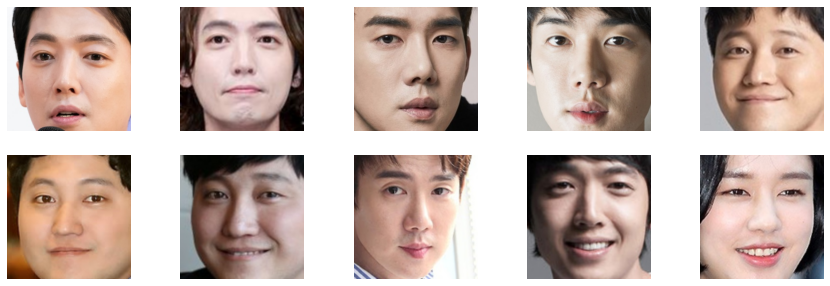

In [32]:
# 결과 이미지 display
for idx in range(0, 3):
    plt.figure(figsize=(15, 5))
    for i in range(1, 11):
        plt.subplot(2, 5, i)
        image_file = output_paths[idx] + str(i) +'.jpg'
        image = cv2.imread(image_file)
        plt.imshow(image)
        cvt_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(cvt_img)
        plt.axis('off')
    plt.show()